In [1]:
import caffe
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os import listdir
from os.path import isfile, join
import numpy as np 
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import json
from pprint import pprint
import scipy.io as sio
from PIL import Image
from caffe import layers as L, params as P # Shortcuts to define the net prototxt.
import os.path as osp
import random
from random import randint
caffe.set_mode_gpu()
#import display_network
%matplotlib inline

In [2]:
#Load image from Newmodel (MemoryData)
init_solver_path = '/home/jsotaloram/active_learning/dm/solver_modelo1.prototxt'
init_solver = caffe.SGDSolver(init_solver_path)

In [7]:
caffe??

In [8]:
train_size = len(dataset_paths_train)
val_size = len(dataset_paths_val)
test_size = len(dataset_paths_test)

data4D = np.zeros([train_size+48,3,48,48],np.float32)
data4DL = np.zeros([train_size+48,1,1,1],np.float32)
data4D_val = np.zeros([val_size,3,48,48],np.float32)
data4DL_val = np.zeros([val_size,1,1,1],np.float32)
data4D_test = np.zeros([test_size+24,3,48,48],np.float32)
data4DL_test = np.zeros([test_size+24,1,1,1],np.float32)

In [14]:
(train_size + 44)/32.

548.96875

In [7]:
def loadSamples(path_part):
    labels = os.listdir(path_part)
    dataset = np.empty((0,2))

    for label in labels:
        samples = sorted(os.listdir(os.path.join(path_part, label)))
        for sample in samples:
            path = os.path.join(path_part, label, sample)
            if os.path.isfile(path):
                dataset = np.concatenate((dataset, np.array([[label, path]])), axis=0)
    return dataset

paths_val_file = '/home/ojperdomoc/Parches48/Modelo_4/Validation/'
paths_train_file ='/home/ojperdomoc/Parches48/Modelo_4/Training/'
paths_test_file = '/home/ojperdomoc/Parches48/Modelo_4/Test/'

dataset_paths_train = loadSamples(paths_train_file)
dataset_paths_val = loadSamples(paths_val_file)
dataset_paths_test = loadSamples(paths_test_file)

print "Train samples: " + str(len(dataset_paths_train))
print "Validation samples: " + str(len(dataset_paths_val))
print "Test samples: " + str(len(dataset_paths_test))

print dataset_paths_train[0]
print dataset_paths_val[0]
print dataset_paths_test[0]

Train samples: 17520
Validation samples: 656
Test samples: 1972
['0'
 '/home/ojperdomoc/Parches48/Modelo_4/Training/0/C0001273_1008_1008_0.jpg']
['0'
 '/home/ojperdomoc/Parches48/Modelo_4/Validation/0/C0014792_1008_1008_0.jpg']
['0' '/home/ojperdomoc/Parches48/Modelo_4/Test/0/C0002422_1008_1008_0.jpg']


In [5]:
init_solver_path = '/home/jsotaloram/active_learning/labels_miccai/solver_modelo1.prototxt'
init_solver = caffe.SGDSolver(init_solver_path)

i=0
#tmp_patch = np.swapaxes(caffe.io.load_image(dataset_paths_train[i][1]),0,2)
#print tmp_patch.shape
#print mean_patch.shape
#print tmp_patch[0,0]
#print mean_patch[0,0]
#mean_patch2 = np.load('/home/jsotaloram/active_learning/labels_miccai/mean4.npy')
#print mean_patch2.shape
#print np.sum(mean_patch2 == mean_patch)
#substracted_mean_patch = tmp_patch -mean_patch
#print substracted_mean_patch[0][0]
mean_root = '/home/ojperdomoc/Predict_mask/Modelo1/'

transformer = caffe.io.Transformer({'data': init_solver.net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(mean_root+'mean4.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
trans_patch = transformer.preprocess('data', caffe.io.load_image(dataset_paths_train[i][1]))

print trans_patch.shape
print data4D[0].shape

data4D[0] = trans_patch
print data4D[0].shape

(3, 48, 48)


NameError: name 'data4D' is not defined

In [6]:
for i in range(len(dataset_paths_train)+48):
    if i<len(dataset_paths_train):
        #Substracting the mean, swaping axes, et al
        trans_patch = transformer.preprocess('data', caffe.io.load_image(dataset_paths_train[i][1]))
        data4D[i] = trans_patch
        data4DL[i,:,:,:] = np.array(dataset_paths_train[i][0])
    else:
        data4D[i,:,:,:] = data4D[0,:,:,:]
        data4DL[i,:,:,:] = data4DL[0,:,:,:]

NameError: name 'data4D' is not defined

In [32]:
for i in range(len(dataset_paths_val)):
    trans_patch = transformer.preprocess('data', caffe.io.load_image(dataset_paths_val[i][1]))
    data4D_val[i] = trans_patch
    data4DL_val[i,:,:,:] = np.array(dataset_paths_val[i][0])

In [33]:
for i in range(len(dataset_paths_test)+24):
    if i<len(dataset_paths_test):
        trans_patch = transformer.preprocess('data', caffe.io.load_image(dataset_paths_test[i][1]))
        data4D_test[i] = trans_patch
        data4DL_test[i,:,:,:] = np.array(dataset_paths_test[i][0])
    else:
        data4D_test[i,:,:,:] = data4D_test[0,:,:,:]
        data4DL_test[i,:,:,:] = data4DL_test[0,:,:,:]

In [34]:
bin_ex_labels_val = []
for i in range(data4DL_val.shape[0]):
    if np.sum(data4DL_val[i].flatten())>0:
        bin_ex_labels_val.append(1)
    else:
        bin_ex_labels_val.append(0)


In [35]:
#986*2 
#1972 de test
#656 val
#17520 
print data4D.shape
print np.sum(np.array(bin_ex_labels_val))

(17568, 3, 48, 48)
328


In [36]:
remain_samples = np.arange(data4D.shape[0])
np.random.shuffle(remain_samples)
print remain_samples

[ 3969  2968  4290 ..., 10127  2133  1836]


In [ ]:
iii = [0,1,2,3]
data4D[iii].shape
#Training the net with random selection of samples and 2 iterations for convergence per sample
init_solver_path = '/home/jsotaloram/active_learning/labels_miccai/solver_modelo_batch.prototxt'
measures = []
reports = []
confusion_matrices = []

init_solver = caffe.SGDSolver(init_solver_path)
remain_samples_rs = np.arange(data4D.shape[0])
np.random.shuffle(remain_samples_rs)
seen_samples_rs = []
cur_samples = []
num_its_cvg = 2
num_init_queries = 10
for i in range(32):
    cur_sumple = remain_samples[randint(0,len(remain_samples))]
    seen_samples_rs.append(cur_sumple)
    cur_samples.append(cur_sumple)
#for seen_sample in seen_samples_rs:
#    for cvg_it in range(num_its_cvg):
#        init_solver.net.set_input_arrays(data4D[cur_samples], np.array([data4DL[cur_samples]], np.float32))
#        init_solver.step(1)
init_solver.net.set_input_arrays(data4D[cur_samples], data4DL[cur_samples])
init_solver.step(1)

In [37]:
np.array([data4DL[cur_samples]], np.float32).shape

NameError: name 'cur_samples' is not defined

In [71]:
#Training the net with random selection of samples and 2 iterations for convergence per sample
init_solver_path = '/home/jsotaloram/active_learning/labels_miccai/solver_modelo_batch.prototxt'
measures = []
reports = []
confusion_matrices = []

init_solver = caffe.SGDSolver(init_solver_path)
remain_samples_rs = np.arange(data4D.shape[0])
np.random.shuffle(remain_samples_rs)
seen_samples_rs = []
num_its_cvg = 2
num_init_queries = 10

train_errors = np.zeros(num_init_queries)

#Train with some positive and some negative samples! not the whole thing of one pass
test_net = init_solver.test_nets[0]
test_net.set_input_arrays(np.expand_dims(data4D_val[0],axis=0), np.array([[[[1]]]], np.float32))
#test_net.set_input_arrays(data4D_test,data4DL_test)

for it in range(num_init_queries):
    pred_labels_val_ex = []
    #print('Current init net iteration: ' + str(it))
    cur_samples = []
    for i in range(32):
        cur_sumple = remain_samples[randint(0,len(remain_samples))]
        seen_samples_rs.append(cur_sumple)
        cur_samples.append(cur_sumple)
    for seen_sample in seen_samples_rs:
        for cvg_it in range(num_its_cvg):
            init_solver.net.set_input_arrays(data4D[cur_samples], np.array([data4DL[cur_samples]], np.float32))
            init_solver.step(1)
    #print "I have seen so far: " + str(len(seen_samples_rs))
    train_errors[it] =  init_solver.net.blobs['loss'].data
    #print train_errors[it]
    #print('Current smpl: ' + str(cur_sumple) + ', TrainERR: ' + str(train_errors[it]) + ', Real label: '+str(np.array([data4DL[cur_sumple]])) +', Label4CurrSmpl: '+ str(init_solver.net.blobs['label'].data[0][-1]))
    
    for j in range(data4D_val.shape[0]):
        test_net.set_input_arrays(np.expand_dims(data4D_val[j], axis=0),  np.array([data4DL_val[j]], np.float32))
        output = test_net.forward()
        pred_labels_val_ex.append(test_net.blobs['prob'].data.flatten().argsort()[-1:-2:-1][0])
        class_report = classification_report(bin_ex_labels_val, pred_labels_val_ex)
    #print class_report
    reports.append(class_report)
    cr_f1 = class_report.split()
    cfm = confusion_matrix(bin_ex_labels_val, pred_labels_val_ex)
    confusion_matrices.append(cfm)
    sensitivity = float(cfm[0,0])/(float(cfm[0,0]) + float(cfm[1,0]))
    specificity = float(cfm[1,1])/(float(cfm[1,1]) + float(cfm[0,1]))
    measures.append((class_report,cfm,sensitivity,specificity))
    if it%2 == 0:
        with open('/home/jsotaloram/active_learning/labels_miccai/results/measures_rs.pkl','w') as f:
            pickle.dump(measures,f)

    print 'Current smpl: ' + str(cur_sumple) + '  with label: '+str(np.array([data4DL[cur_sumple]]))+', TrainERR: ' + str(train_errors[it]) + ', Samples seen: ' + str(len(seen_samples_rs)) +', F1, so far:' + str(cr_f1[-2]) + ", Sensitivity: " + str(sensitivity), ", Specificity: " + str(specificity)

Current smpl: 13437  with label: [[[[ 1.]]]], TrainERR: 0.582055211067, Samples seen: 1, F1, so far:0.39, Sensitivity: 1.0 , Specificity: 0.514170040486
Current smpl: 139  with label: [[[[ 0.]]]], TrainERR: 0.410372853279, Samples seen: 2, F1, so far:0.50, Sensitivity: 1.0 , Specificity: 0.548596112311
Current smpl: 1757  with label: [[[[ 0.]]]], TrainERR: 0.349761784077, Samples seen: 3, F1, so far:0.54, Sensitivity: 1.0 , Specificity: 0.560706401766
Current smpl: 8806  with label: [[[[ 1.]]]], TrainERR: 0.129326850176, Samples seen: 4, F1, so far:0.55, Sensitivity: 1.0 , Specificity: 0.56570155902
Current smpl: 1925  with label: [[[[ 0.]]]], TrainERR: 0.0800098329782, Samples seen: 5, F1, so far:0.56, Sensitivity: 1.0 , Specificity: 0.568232662192
Current smpl: 2050  with label: [[[[ 0.]]]], TrainERR: 0.149055361748, Samples seen: 6, F1, so far:0.56, Sensitivity: 0.992063492063 , Specificity: 0.569662921348
Current smpl: 948  with label: [[[[ 0.]]]], TrainERR: 0.00637556659058, Sampl

In [39]:
1+1

2

In [45]:
it = 0
pred_labels_val_ex = []
reports = []
confusion_matrices = []
for j in range(data4D_val.shape[0]):
    test_net.set_input_arrays(np.expand_dims(data4D_val[j], axis=0),  np.array([data4DL_val[j]], np.float32))
    output = test_net.forward()
    pred_labels_val_ex.append(test_net.blobs['prob'].data.flatten().argsort()[-1:-2:-1][0])
class_report = classification_report(bin_ex_labels_val, pred_labels_val_ex)
#print class_report
reports.append(class_report)
cr_f1 = class_report.split()
cfm = confusion_matrix(bin_ex_labels_val, pred_labels_val_ex)
confusion_matrices.append(cfm)
sensitivity = float(cfm[0,0])/(float(cfm[0,0]) + float(cfm[1,0]))
specificity = float(cfm[1,1])/(float(cfm[1,1]) + float(cfm[0,1]))


print('Current smpl: ' + str(cur_sumple) + 'Real label: '+str(np.array([data4DL[cur_sumple]]))+', TrainERR: ' + str(train_errors[it]) + ', Samples seen: ' + str(len(seen_samples_rs)) 
+'F1, so far:' + str(cr_f1[-2]) + ", Sensitivity: " + str(sensitivity), ", Specificity: " + str(specificity))

F1 for iteration 0 with 0 samples seen with random selection: 0.78


In [59]:
from sklearn import metrics
cfm= confusion_matrix(bin_ex_labels_val, pred_labels_val_ex)
sensitivity = float(cfm[0,0])/(float(cfm[0,0]) + float(cfm[1,0]))
specificity = float(cfm[1,1])/(float(cfm[1,1]) + float(cfm[0,1]))


print "Sensitivity: " + str(sensitivity)
print "Specificity: " + str(specificity)
print cfm
print cfm[1,1]

Sensitivity: 0.996666666667
Specificity: 0.708100558659
[[299 209]
 [  1 507]]
507


In [41]:
print np.sum(bin_ex_labels_val)
print np.sum(pred_labels_val_ex)
class_report
get_average_precision(bin_ex_labels_val, pred_labels_val_ex, printable=True)

508
716
[[ 0.58858268  0.41141732]
 [ 0.0019685   0.9980315 ]]


0.79330708661417315

In [ ]:
#2) Training the net 
init_solver_path = '/home/jsotaloram/active_learning/labels_miccai/solver_modelo1.prototxt'
init_solver = caffe.SGDSolver(init_solver_path)
num_init_queries = 1
train_errors = np.zeros(num_init_queries)

#init_solver.net.set_input_arrays(data4D, data4DL)
#Train with some positive and some negative samples! not the whole thing of one pass
test_net = init_solver.test_nets[0]
test_net.set_input_arrays(np.expand_dims(data4D_val[0],axis=0), np.array([[[[1]]]], np.float32))
#test_net.set_input_arrays(data4D_test,data4DL_test)
pred_labels_val_ex = []
for it in range(num_init_queries):
    #print('Current init net iteration: ' + str(it))
    cur_sumple = randint(0,data4D.shape[0]-1)     
    init_solver.net.set_input_arrays(np.expand_dims(data4D[cur_sumple], axis=0 ), np.array([data4DL[cur_sumple]], np.float32))
    train_errors[it] =  init_solver.net.blobs['loss'].data
    init_solver.step(1)

    print('Current smpl: ' + str(cur_sumple) + ', TrainERR: ' + str(train_errors[it]) + ', Real label: '+str(np.array([data4DL[cur_sumple]])) +', Label4CurrSmpl: '+ str(init_solver.net.blobs['label'].data[0][-1]))
    if it%10==0:
        for j in range(data4D_val.shape[0]):
            test_net.set_input_arrays(np.expand_dims(data4D_val[j], axis=0),  np.array([data4DL_val[j]], np.float32))
            output = test_net.forward()
            pred_labels_val_ex.append(test_net.blobs['prob'].data.flatten().argsort()[-1:-2:-1][0])
        cr_f1 = classification_report(bin_ex_labels_val, pred_labels_val_ex).split()
        print 'F1 for iteration ' + str(it)+' with '+ str(it)+' samples seen with random selection: ' + str(cr_f1[-2])
#initf1 = float(cr_f1[-2])



In [75]:
print np.array([data4DL[7302]], np.float32)
np.sum(data4D_val.flatten())

[[[[ 0.]]]]


2926830.5

(3, 48, 48)


In [18]:
#2) Training the net with EGC for selecting the most relevant patches for training the model incrementaly


[active_samples_updt_params, actv_smpls_values] = egc(solver_al,remain_samples_al_seen,data4D,'','','','',num_active_selections+1)  


Current init net iteration: 0
Current init net iteration: 1
Current init net iteration: 2
Current init net iteration: 3
Current init net iteration: 4
Current init net iteration: 5
Current init net iteration: 6
Current init net iteration: 7
Current init net iteration: 8
Current init net iteration: 9
Current init net iteration: 10
Current init net iteration: 11
Current init net iteration: 12
Current init net iteration: 13
Current init net iteration: 14
Current init net iteration: 15
Current init net iteration: 16
Current init net iteration: 17
Current init net iteration: 18
Current init net iteration: 19


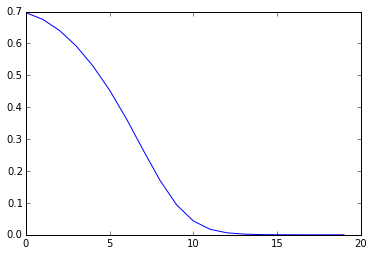

In [19]:
x = np.arange(len(train_errors))

plt.plot(x, train_errors)
#TO CHECK: How is changing learning rate in the internal layers!


In [20]:
len(dataset_paths_test)

1976

In [21]:
data4D_test.shape

(2000, 3, 48, 48)

In [22]:
pred_labels_test_ex = []
for i in range(data4D_test.shape[0]):
    test_net.set_input_arrays(np.expand_dims(data4D_test[i],axis=0), data4DL_test[i].reshape(1,1,1,1)) 
    output = test_net.forward()
    pred_labels_test_ex.append(test_net.blobs['prob'].data.flatten().argsort()[-1:-2:-1][0])
len(pred_labels_test_ex)

2000

In [23]:
pred_labels_test_ex[1200]

0

##Loading Test Data

We define the root where our data lies and the paths to the data

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

test_image = "DS000F4H.JPG"
original = Image.open(test_image)
#original1 = np.array(original)
#original.show()
#plt.imshow(original)
width, height = original.size
#net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image('/home/ojperdomoc/DS000F4H.jpg'))
#plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

(960, 1440, 3)
(48, 48, 3)


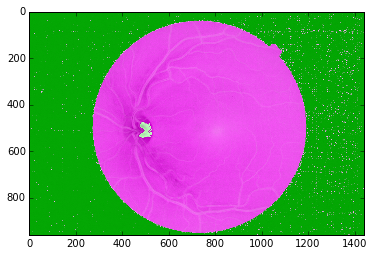

In [20]:
original1 = np.array(original)
print original1.shape
a1=np.ones((height,width))
matriz_RGB=np.zeros((height,width,3))
blue=a1*35.1219618056
green=a1*81.665786111
red=a1*154.825520833
matriz_RGB[:,:,0]=red
matriz_RGB[:,:,1]=green
matriz_RGB[:,:,2]=blue
original1 = original1 - matriz_RGB
cambio = original1[:,:,0]
original1[:,:,0] = original1[:,:,2]
original1[:,:,2] = cambio
patche1 = original1[500:548,560:608]
print patche1.shape
plt.imshow(original1)

In [21]:
all_patches = []
for i in range(0, height-48, 1):
        for j in range(0, width-48, 1):
            all_patches.append(original1[i:i+48,j:j+48])
            #print contador
            #if contador>1000: break
            #contador = contador + 1

In [22]:
all_patches = np.array(all_patches)
print all_patches.shape
#all_patches.reshape(1382400,48,48,3)
#all_patches[1382397].shape

(1269504, 48, 48, 3)


In [23]:

#for i in range(0,1269504,2000):
    #data4D_test = np.swapaxes(all_patches[i:i+2000],1,3)
    #data4D_test = np.ascontiguousarray(data4D_test, dtype=np.float32)

In [26]:
data4D_test = np.swapaxes(all_patches[0:2000],1,3)
data4D_test = np.ascontiguousarray(data4D_test, dtype=np.float32)
print data4D.shape, data4DL.shape, data4D_test.shape, data4DL_test.shape
test_net.set_input_arrays(data4D_test, data4DL_test)
init_solver.net.set_input_arrays(data4D, data4DL)

(14656, 3, 48, 48) (14656, 1, 1, 1) (2000, 3, 48, 48) (2000, 1, 1, 1)


In [53]:
test_net.set_input_arrays(data4D_test, data4DL_test)
pred_labels = []

In [54]:
output = test_net.forward()
pred_labels.append(test_net.blobs['prob'].data.flatten().argsort()[-1:-2:-1][0])

In [59]:
np.sum(data4DL_test)

988.0

In [56]:
  [(k, v.data.shape) for k, v in test_net.blobs.items()]

[('data', (100, 3, 48, 48)),
 ('label', (100, 1, 1, 1)),
 ('scale', (100, 3, 48, 48)),
 ('conv1', (100, 20, 44, 44)),
 ('pool1', (100, 20, 22, 22)),
 ('conv2', (100, 50, 18, 18)),
 ('pool2', (100, 50, 9, 9)),
 ('ip1', (100, 500)),
 ('ip2', (100, 2)),
 ('prob', (100, 2))]

In [39]:
pred = []
for path in paths:
    net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(path))
    out = net.forward()
    print("Predicted class is #{}.".format(out['prob'].argmax()))
    print(out['prob'])
    print (path)
    pred.append(labels[out['prob'].argmax()])
    y_pred = np.array(pred, dtype=np.int32)

NameError: name 'paths' is not defined

In [37]:
y_pred

NameError: name 'y_pred' is not defined

##Using Average Precision

Here we are going to show test results for these architecures:
- CS16-CS32-FC128
- CS32-CS64-FC256
- CS128-CS128-FC128
- CS256-CS256-FC256
- LW_CS128-CS128-FC128
- CS128-CS256-CS256-FC512  

Models were chosen as the best ones during validation

In [18]:
def get_average_precision(y_true, y_scores, printable=False):
    cm = confusion_matrix(y_true, y_scores)
    cm_normalized = []
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    a = np.mean(np.diag(cm_normalized))
    if printable:
        print cm_normalized
    return a

In [73]:
def test_model(model_pairs, paths):
    '''
    This function given a list of test paths test different models(tuple of deploy.prototxt and caffemodel)
    
    paths consist of a list of paths to the test data
    model_pairs is a pair of paths to deploy.prototxt and caffemodel file
    '''
    
    caffe.set_device(0)
    caffe.set_mode_gpu()
    y_pred = []
    for deploy, caffemodel in model_pairs:
         
        cropx = net.blobs['data'].data.shape[2]
        cropy = net.blobs['data'].data.shape[3]
        # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
        transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
        transformer.set_transpose('data', (2,0,1))
        transformer.set_mean('data', np.load(asar_root + 'mean.npy').mean(1).mean(1)) # mean pixel
        transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
        transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
        net.blobs['data'].reshape(50,3,cropx,cropy)
        
        pred = []
        for path in paths:
            net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(path))
            out = net.forward()
            #print("Predicted class is #{}.".format(out['prob'].argmax()))
            pred.append(labels[out['prob'].argmax()])
        y_pred.append(np.array(pred, dtype=np.int32))
    return y_pred

In [74]:
get_average_precision(y_true, y_pred, printable=True)

[[ 0.99595142  0.00404858]
 [ 0.00101215  0.99898785]]


0.99746963562753033

In [77]:
accuracy_score(y_true, y_pred)

0.5

In [78]:
model_pairs = (('modelo1.prototxt', 'modelo1.caffemodel'),\
               ('2Layer.prototxt', '2Layer.caffemodel'),\
               ('2Layer_1Weight.prototxt', '2Layer_1Weight.caffemodel'),\
               ('3Layer.prototxt', '3Layer.caffemodel'),\
               ('3Layer_2Weights.prototxt', '3Layer_2Weights.caffemodel'))

In [79]:
y_pred = test_model(model_pairs, paths)

In [80]:
get_average_precision(y_true, y_pred[0], printable=True)

[[ 0.99595142  0.00404858]
 [ 0.00101215  0.99898785]]


0.99746963562753033

In [81]:
a=[]

In [82]:
for pred in y_pred:
    print get_average_precision(y_true, pred, printable=True)

[[ 0.99595142  0.00404858]
 [ 0.00101215  0.99898785]]
0.997469635628
[[ 0.48582996  0.51417004]
 [ 0.44129555  0.55870445]]
0.522267206478
[[ 0.51012146  0.48987854]
 [ 0.35020243  0.64979757]]
0.57995951417
[[ 0.50303644  0.49696356]
 [ 0.51012146  0.48987854]]
0.496457489879
[[ 0.54048583  0.45951417]
 [ 0.46659919  0.53340081]]
0.536943319838


In [78]:
from caffe import layers as L
from caffe import params as P

def lenet(lmdb, batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                            transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.ip1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    n.ip2 = L.InnerProduct(n.relu1, num_output=2, weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()
    
with open('/data1/caffe-examples/examples/EX_Class/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('/data1/caffe-examples/examples/EX_Class/mnist_train_lmdb', 64)))
    
with open('/data1/caffe-examples/examples/EX_Class/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('/data1/caffe-examples/examples/EX_Class/mnist_test_lmdb', 100)))
                                                                                     

In [79]:
!cat /data1/caffe-examples/examples/EX_Class/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "/data1/caffe-examples/examples/EX_Class/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "ip1"
 

In [80]:
!cat /data1/caffe-examples/examples/EX_Class/solver.prototxt

test_iter: 8
test_interval: 32
base_lr: 0.01
display: 4
max_iter: 1920
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 634
snapshot: 32
snapshot_prefix: "snapshot"
solver_mode: GPU
net: "train_val.prototxt"
solver_type: SGD


In [35]:
caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('/data1/caffe-examples/examples/EX_Class/solver.prototxt')

In [36]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (32, 3, 256, 256)),
 ('label', (32,)),
 ('scale', (32, 3, 256, 256)),
 ('conv1', (32, 60, 252, 252)),
 ('pool1', (32, 60, 126, 126)),
 ('conv2', (32, 100, 122, 122)),
 ('pool2', (32, 100, 61, 61)),
 ('ip1', (32, 500)),
 ('ip2', (32, 2)),
 ('loss', ())]

In [ ]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (60, 3, 5, 5)),
 ('conv2', (100, 60, 5, 5)),
 ('ip1', (500, 372100)),
 ('ip2', (2, 500))]

In [1]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

NameError: name 'solver' is not defined

In [ ]:
solver.step(1)

In [ ]:
%%time
niter = 200
test_interval = 5
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))
output = np.zeros((niter, 8, 2))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

In [ ]:
from pylab import *
%matplotlib inline
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')

In [52]:
# ecg computes which samples are more informative in the model w.r.t. to the norm of gradients
# assumes that the model is a caffe net with memory data layer
# returns the gradients and the index of the selected samples
def egc(cf_model, samples, data4D, labels4D, queries, mode_egc, layer, num_active_selections):
    expected_value_samples = []
    samples_grads = []
    for cur_sampl in samples:
        #For each sample we compute the sum of its expected gradient vals
        sum_expected_vals_cur = 0 
        for lbl in range(2):
            cf_model.net.set_input_arrays(data4D[cur_sampl].reshape(1,3,48,48), np.array([[[[lbl]]]], np.float32))
            sum_expected_vals_cur +=cf_model.net.forward()['prob'].flatten()[lbl]*np.linalg.norm(cf_model.net.backward(diffs=['ip1'])['ip1'])
            samples_grads.append(np.linalg.norm(cf_model.net.backward(diffs=['ip1'])['ip1'])) 
        expected_value_samples.append(sum_expected_vals_cur) 
    #Now lets sort by most informative samples
    actv_smpls_values = zip(samples, expected_value_samples)
    actv_smpls_values = sorted(actv_smpls_values, key=lambda x: x[1])
    active_samples_updt_params = [actv_smpls_values[-k][0] for k in range(1,num_active_selections)] #just the k most informative samples
    return [active_samples_updt_params, actv_smpls_values]


In [18]:
len(remain_samples)

14656

In [42]:
cur_sampl = 0
data4D[cur_sampl].shape

NameError: name 'data4D' is not defined

In [54]:
init_solver_path = '/home/jsotaloram/active_learning/labels_miccai/solver_modelo1.prototxt'
all_egc_measures = []
reports = []
confusion_matrices = []
init_solver = caffe.SGDSolver(init_solver_path)
remain_samples = np.arange(data4D.shape[0])
np.random.shuffle(remain_samples)
seen_samples_rs = []
all_gradients = []


num_its_cvg = 2
num_init_queries = 10
num_active_selections = 1


train_errors = np.zeros(num_init_queries)

#Train with some positive and some negative samples! not the whole thing of one pass               
all_samples_seen_al_seen = []
test_net = init_solver.test_nets[0]
test_net.set_input_arrays(np.expand_dims(data4D_val[0],axis=0), np.array([[[[1]]]], np.float32))
#test_net.set_input_arrays(data4D_test,data4DL_test)                                                                                                                                                                
for rand_it in range(1):
    measures = []
    for it in range(num_init_queries):
        [active_samples_updt_params, actv_smpls_values] = egc(init_solver,remain_samples,data4D,'','','','',num_active_selections+1)  
        all_gradients.append(actv_smpls_values)
        for aux_idx in range(len(active_samples_updt_params)):        
            cur_sumple = active_samples_updt_params[aux_idx]
            all_samples_seen_al_seen.append(cur_sumple)

        pred_labels_val_ex = []
        #print('Current init net iteration: ' + str(it))                                                                                                                                                            
        #cur_sumple = remain_samples[randint(0,len(remain_samples))]
        #seen_samples_rs.append(cur_sumple)
        #np.delete(remain_samples,cur_sumple)
        for seen_sample in all_samples_seen_al_seen:
            for cvg_it in range(num_its_cvg):
                init_solver.net.set_input_arrays(np.expand_dims(data4D[seen_sample], axis=0 ), np.array([data4DL[seen_sample]], np.float32))
                init_solver.step(1)
                #print "I have seen so far: " + str(len(seen_samples_rs))                                                                                                                                           
        train_errors[it] =  init_solver.net.blobs['loss'].data
        for act_sel_sample in active_samples_updt_params:#[cur_selected_act_sample]:
             np.delete(remain_samples,act_sel_sample)


                #print train_errors[it]                                                                                                                                                                             
                #Evaluation code                                                                                                                                                                                    
        for j in range(data4D_val.shape[0]):
            test_net.set_input_arrays(np.expand_dims(data4D_val[j], axis=0),  np.array([data4DL_val[j]], np.float32))
            output = test_net.forward()
            pred_labels_val_ex.append(test_net.blobs['prob'].data.flatten().argsort()[-1:-2:-1][0])
#        class_report = classification_report(bin_ex_labels_val, pred_labels_val_ex)                                                                                                                                
        #print class_report                                                                                                                                                                                         
#        cr_f1 = class_report.split()                                                                                                                                                                               

        class_report = classification_report(bin_ex_labels_val, pred_labels_val_ex)
        reports.append(class_report)
        cr_f1 = class_report.split()
        cfm = confusion_matrix(bin_ex_labels_val, pred_labels_val_ex)
        confusion_matrices.append(cfm)
        sensitivity = float(cfm[0,0])/(float(cfm[0,0]) + float(cfm[1,0]))
        specificity = float(cfm[1,1])/(float(cfm[1,1]) + float(cfm[0,1]))
        measures.append((class_report,cfm,sensitivity,specificity,train_errors[it]))
        if it%100 == 0:
            with open('/home/jsotaloram/active_learning/labels_miccai/results/measures_egc_'+str(rand_it)+'.pkl','w') as f:
                pickle.dump(measures,f)
        print 'Current smpl: ' + str(cur_sumple) + '  with label: '+str(np.array([data4DL[cur_sumple]]))+', TrainERR: ' + str(train_errors[it]) + ', Samples seen: ' + str(len(seen_samples_rs)) +', F1, so far:' + str(cr_f1[-2]) + ", Sensitivity: " + str(sensitivity), ", Specificity: " + str(specificity)
    all_egc_measures.append(measures)


Current smpl: 11179  with label: [[[[ 1.]]]], TrainERR: 0.542788743973, Samples seen: 0, F1, so far:0.34, Sensitivity: 0.666666666667 , Specificity: 0.500493583416
Current smpl: 11889  with label: [[[[ 1.]]]], TrainERR: 0.594326376915, Samples seen: 0, F1, so far:0.34, Sensitivity: 1.0 , Specificity: 0.500492610837
Current smpl: 2741  with label: [[[[ 0.]]]], TrainERR: 0.845063090324, Samples seen: 0, F1, so far:0.34, Sensitivity: 1.0 , Specificity: 0.500492610837
Current smpl: 2834  with label: [[[[ 0.]]]], TrainERR: 0.804090082645, Samples seen: 0, F1, so far:0.34, Sensitivity: 1.0 , Specificity: 0.501976284585
Current smpl: 2878  with label: [[[[ 0.]]]], TrainERR: 0.689013838768, Samples seen: 0, F1, so far:0.40, Sensitivity: 1.0 , Specificity: 0.515736040609
Current smpl: 2198  with label: [[[[ 0.]]]], TrainERR: 0.591955304146, Samples seen: 0, F1, so far:0.58, Sensitivity: 1.0 , Specificity: 0.578587699317
Current smpl: 6284  with label: [[[[ 0.]]]], TrainERR: 0.445922493935, Samp

In [44]:
init_solver.net.blobs['ip1'].data[0].shape

(500,)

In [41]:
init_solver.net.blobs.items()

[('data', <caffe._caffe.Blob at 0x7f22ddae6b90>),
 ('label', <caffe._caffe.Blob at 0x7f22ddae6938>),
 ('scale', <caffe._caffe.Blob at 0x7f22ddae66e0>),
 ('conv1', <caffe._caffe.Blob at 0x7f22ddae6c08>),
 ('pool1', <caffe._caffe.Blob at 0x7f22ddae6758>),
 ('conv2', <caffe._caffe.Blob at 0x7f22ddae69b0>),
 ('pool2', <caffe._caffe.Blob at 0x7f22ddae6a28>),
 ('ip1', <caffe._caffe.Blob at 0x7f22ddae6aa0>),
 ('ip2', <caffe._caffe.Blob at 0x7f22ddae6cf8>),
 ('ip2_ip2_0_split_0', <caffe._caffe.Blob at 0x7f22ddae6848>),
 ('ip2_ip2_0_split_1', <caffe._caffe.Blob at 0x7f22ddae68c0>),
 ('prob', <caffe._caffe.Blob at 0x7f22ddae67d0>),
 ('loss', <caffe._caffe.Blob at 0x7f22ddae6b18>)]

In [8]:
from results_analysis import *

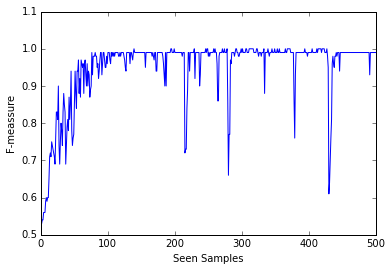

In [22]:
plot_samples_measures('/home/jsotaloram/active_learning/labels_miccai/results/', 'measures_rsNPtest_BATCH_fxdLR500.pkl')

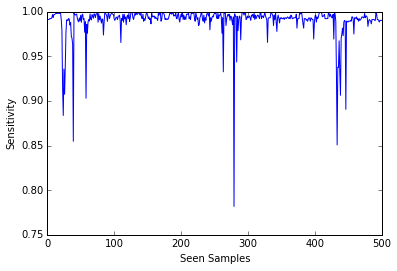

In [20]:
    plot_samples_measures('/home/jsotaloram/active_learning/labels_miccai/results/', 'measures_rsNPtest_BATCH_fxdLR500.pkl', 's_sensit')

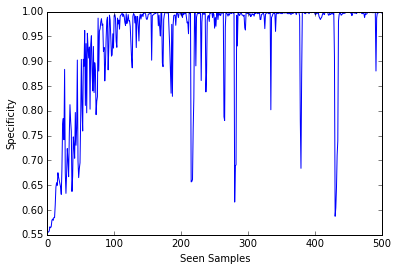

In [21]:
plot_samples_measures('/home/jsotaloram/active_learning/labels_miccai/results/', 'measures_rsNPtest_BATCH_fxdLR500.pkl', 's_specif')

In [12]:
300 *32

9600

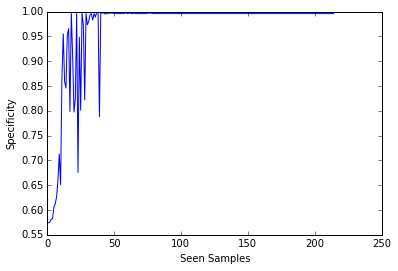

In [24]:
plot_samples_measures('/home/jsotaloram/active_learning/labels_miccai/results/', 'measures_egc_testBATCH_it0.pkl', 's_specif')

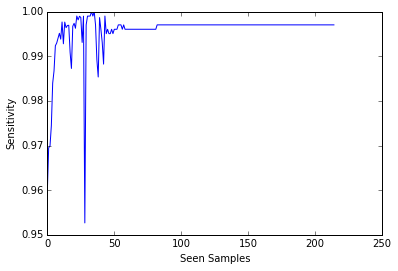

In [25]:
plot_samples_measures('/home/jsotaloram/active_learning/labels_miccai/results/', 'measures_egc_testBATCH_it0.pkl', 's_sensit')

In [29]:
a = np.load('/home/jsotaloram/active_learning/labels_miccai/results/measures_egc_testBATCH_it0.pkl')
b = np.load('/home/jsotaloram/active_learning/labels_miccai/results/measures_rsNPtest_BATCH_fxdLR250.pkl')

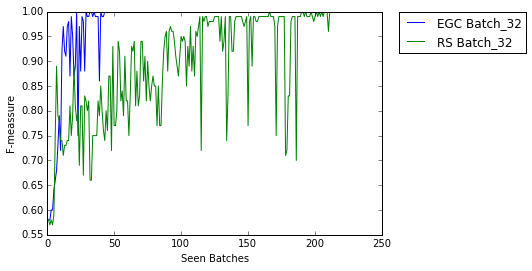

In [36]:
f_meassures_al = []
f_meassures_rs = []

for i in range(len(a)):
    f_meassures_al.append(float(a[i][0].split()[-2]))
    f_meassures_rs.append(float(b[i][0].split()[-2]))
x = np.arange(len(f_meassures_al))


plt.ylabel('F-meassure')
plt.xlabel('Seen Batches')
plt.plot(x, f_meassures_al, label="EGC Batch_32")
plt.plot(x, f_meassures_rs, label="RS Batch_32")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('/home/jsotaloram/active_learning/labels_miccai/results/resultsALvsRS_batch32_sampls_fmeasure.png')

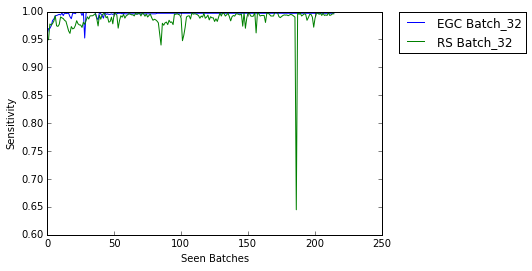

In [37]:
sensit_meassures_al = []
sensit_meassures_rs = []

for i in range(len(a)):
    sensit_meassures_al.append(a[i][2])
    sensit_meassures_rs.append(b[i][2])
x = np.arange(len(sensit_meassures_rs))


plt.ylabel('Sensitivity')
plt.xlabel('Seen Batches')
plt.plot(x, sensit_meassures_al, label="EGC Batch_32")
plt.plot(x, sensit_meassures_rs, label="RS Batch_32")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('/home/jsotaloram/active_learning/labels_miccai/results/resultsALvsRS_batch32_sampls_sensitivity.png')

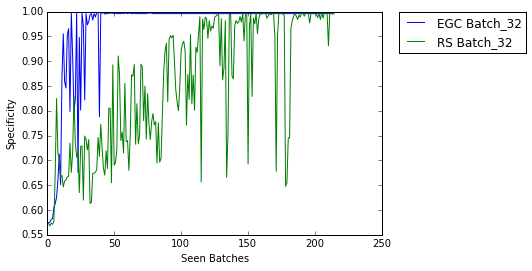

In [38]:
sensit_meassures_al = []
sensit_meassures_rs = []

for i in range(len(a)):
    sensit_meassures_al.append(a[i][3])
    sensit_meassures_rs.append(b[i][3])
x = np.arange(len(sensit_meassures_rs))


plt.ylabel('Specificity')
plt.xlabel('Seen Batches')
plt.plot(x, sensit_meassures_al, label="EGC Batch_32")
plt.plot(x, sensit_meassures_rs, label="RS Batch_32")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('/home/jsotaloram/active_learning/labels_miccai/results/resultsALvsRS_batch32_sampls_specificity.png')

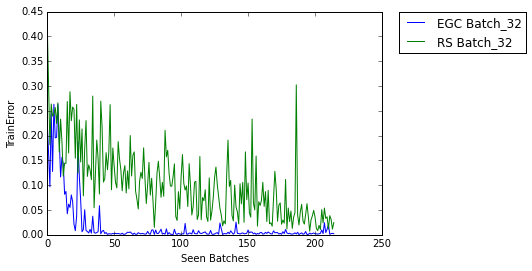

In [41]:
trainerr_meassures_al = []
trainerr_meassures_rs = []

for i in range(len(a)):
    trainerr_meassures_al.append(a[i][-1])
    trainerr_meassures_rs.append(b[i][-1])
x = np.arange(len(trainerr_meassures_al))


plt.ylabel('TrainError')
plt.xlabel('Seen Batches')
plt.plot(x, trainerr_meassures_al, label="EGC Batch_32")
plt.plot(x, trainerr_meassures_rs, label="RS Batch_32")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('/home/jsotaloram/active_learning/labels_miccai/results/resultsALvsRS_batch32_sampls_trainerr.png')